# Python codes for [Introduction to Computional Stochastic PDEs, CUP 2014](http://www.cambridge.org/gb/academic/subjects/mathematics/differential-and-integral-equations-dynamical-systems-and-co/introduction-computational-stochastic-pdes?format=PB&isbn=9780521728522)

Written by [T. Shardlow](http://people.bath.ac.uk/tjs42/) Dec 2015
# Chapter 10





In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from builtins import (bytes, dict, int, list, object, range, str,
                      ascii, chr, hex, input, next, oct, open,
                      pow, round, super, filter, map, zip)
from future.builtins.disabled import (apply, cmp, coerce, execfile,
                                      file, long, raw_input, reduce, reload,
                                      unicode, xrange, StandardError)
#
import sys

In [2]:
from math import *
# Numpy
import numpy as np
from numpy import matlib
fft=np.fft.fft
fft2=np.fft.fft2
ifft=np.fft.ifft
ifft2=np.fft.ifft2
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Scipy
import scipy
from scipy import sparse
from scipy.sparse import linalg
from scipy import optimize
from scipy import fftpack
#
def icspde_dst1(u):
    return scipy.fftpack.dst(u,type=1,axis=0)/2

The discrete sine transform is used to sample increment of a Wiener process.

In [3]:
def get_onedD_bj(dtref,J,a,r):
    """
    Alg 10.1 Page 440
    """
    jj=np.arange(1,J)
    myeps=0.001
    root_qj=jj ** - ((2 * r + 1 + myeps) / 2)
    bj=root_qj * sqrt(2 * dtref / a)
    return bj
#
def get_onedD_dW(bj,kappa,iFspace,M,s0):
    """
    Alg 10.2 Page 441
    """
    if (kappa == 1):
        nn=s0.randn(M,bj.size)
    else:
        nn=np.sum(s0.randn(kappa,M,bj.size),axis=0)
    X=(bj*nn)
    if (iFspace == 1):
        dW=X
    else:
        dW=icspde_dst1(np.squeeze(X))
        dW=dW.reshape(X.shape)
    return dW

We show one realisation.

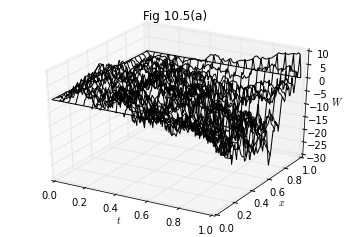

In [4]:
dtref=0.01; kappa=100; r=1/2; J=128; a=1;
bj=get_onedD_bj(dtref,J,a,r)
s0=np.random.RandomState()
dW=get_onedD_dW(bj,kappa,0,1,s0)
WW=np.zeros((J+1,100)); t=np.zeros(100)
for k in range(99):
  dW=get_onedD_dW(bj,kappa,0,1,s0)
  WW[1:-1,k+1]=WW[1:-1,k]+dW
  t[k+1]=(k+1)*dtref
x=np.linspace(0,a,J-1)
#
ax = plt.gca()
ax = plt.gca(projection='3d')
[T,X]=np.meshgrid(t,np.linspace(0,a,J+1))
CS=ax.plot_wireframe(T,X,WW,rstride=5,cstride=5,colors='k')
s=ax.set_xlabel(r'$t$')
s=ax.set_ylabel(r'$x$')
s=ax.set_zlabel(r'$W$')
s=ax.set_title(r'Fig 10.5(a)') # change r to 2 for Fig 10.5(b)

For periodic boundary conditions, we use the discrete Fourier transform via the `fft` in the following codes.

In [5]:
def get_oned_bj(dtref,J,a,r):
    """
    Alg 10.3 Page 442
    """
    jj=np.hstack([np.arange(1,J // 2+1), np.arange(- J // 2 + 1,0)])
    myeps=0.001
    root_qj=np.hstack([[0], np.abs(jj) ** - ((2 * r + 1 + myeps) / 2)])
    bj=root_qj * sqrt(dtref / a) * J
    return bj
#
def get_oned_dW(bj,kappa,iFspace,M,s0):
    """
    Alg 10.4 Page 442
    """
    J=bj.size
    if (kappa == 1):
        nn=s0.randn(M,J)
    else:
        nn=np.sum(s0.randn(kappa,M,J),0)
    nn2=np.vstack([nn[0:1,:],
                   (nn[1:J//2,:] + 1j * nn[J//2 + 1:J,:]) / sqrt(2),
                   nn[J//2:J//2+1,:],
                   (nn[J//2-1:0:-1,:] - 1j * nn[J-1:J // 2 :-1,:])/ sqrt(2)
               ])
    X=bj*nn2
    if (iFspace == 1):
        dW=X
    else:
        dW=np.real(ifft(X))
    return dW


The code is similar for two space dimensions.

In [6]:
fft2=np.fft.fft2
ifft2=np.fft.ifft2
#
def get_twod_bj(dtref,J,a,alpha):
    """
    Alg 4.5 Page 443
    """
    lambdax=2 * pi * np.hstack([np.arange(0,J[0]//2 +1), np.arange(- J[0]//2 + 1,0)]) / a[0]
    lambday=2 * pi * np.hstack([np.arange(0,J[1]//2 +1), np.arange(- J[1]//2 + 1,0)]) / a[1]
    lambdaxx,lambdayy=np.meshgrid(lambdax,lambday,indexing='ij')
    root_qj=np.exp(- alpha * (lambdaxx ** 2 + lambdayy ** 2) / 2)
    bj=root_qj * sqrt(dtref) * J[0] * J[1] / sqrt(a[0] * a[1])
    return bj
#
def get_twod_dW(bj,kappa,M):
    """
    Alg 10.6 Page 444
    """
    J=bj.shape
    if (kappa == 1):
        nn=np.random.randn(M,J[0],J[1],2)
    else:
        nn=np.sum(np.random.randn(kappa,M,J[0],J[1],2),0)
    nn2=np.dot(nn,np.array([1,1j]));
    tmp=ifft2(bj*nn2)
    dW1=np.real(tmp)
    dW2=np.imag(tmp)
    return dW1,dW2

Here's a realisation.

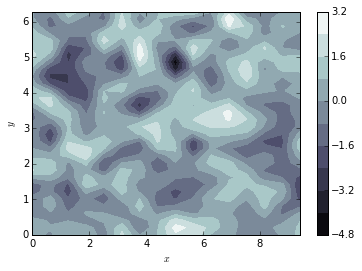

In [7]:
J=[32,16]; dtref=0.01; kappa=100; a=[2*pi,3*pi]
alpha=0.05; bj=get_twod_bj(dtref,J,a,alpha)
W1,W2=get_twod_dW(bj,kappa,1)
#
gridx=np.linspace(0,a[0],J[0])
gridy=np.linspace(0,a[1],J[1])
ax = plt.gca()
#ax.plot_wireframe(T,X,ut,rstride=16,cstride=1000,colors='k')
CS=ax.contourf(gridy,gridx,W1[0,:,:],10,cmap=plt.cm.bone)
#ax.set_zlabel(r'$u$')
s=ax.set_xlabel(r'$x$')
s=ax.set_ylabel(r'$y$')
s=plt.colorbar(CS)

The finite-difference method can be applied to stochastic PDEs. Here, we do so for a stochastic reaction-diffusion equation. The circulant-embedding method of Chapter 6 is used to sample increments of the Wiener process.

In [8]:
import ch6
def spde_fd_n_exp(u0,T,a,N,J,epsilon,sigma,ell,fhandle):
    """
    Alg 10.7 Page 456
    """
    Dt=T / N;    t=np.linspace(0,T,N+1)
    h=a / J;    e=np.ones(J + 1)
    A=scipy.sparse.diags([-1,2,-1],[-1,0,1],
                         shape=(J+1,J+1),
                         format='csc')
    ind=np.arange(0,J + 1);    A[0,1]=2;    A[-1,-2]=2
    EE=scipy.sparse.identity(ind.size,format='csc') + (Dt * epsilon/h**2) * A 
    ut=np.zeros((J + 1,t.size)) # initialize vectors
    ut[:,0]=u0;    u_n=u0[ind]
    flag=False
    EEinv=sparse.linalg.factorized(EE)
    
    for n in range(N):
        fu=fhandle(u_n)
        if flag == False:
            x,dW,dW2=ch6.circulant_exp(ind.size,h,ell)
            flag=True
        else:
            dW=dW2
            flag=False
        u_new=EEinv(u_n + Dt * fu+ sigma * sqrt(Dt) * dW) 
        ut[ind,n + 1]=u_new
        u_n=u_new
    return t,ut

Here's an example using the Nagumo PDE defined in Chapter 3.

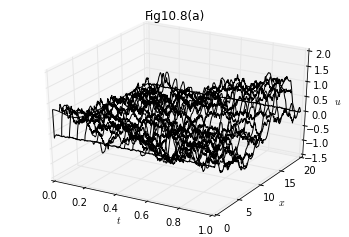

In [9]:
import ch3
#
a=20; J=1024; x=np.linspace(0,a,J+1); u0=1/(1+np.exp(-(2-x)/sqrt(2)));
ell=1; N=int(1e3); T=1; epsilon=1; sigma=1;
t,ut=spde_fd_n_exp(u0,T,a,N,J,epsilon,sigma,ell,   ch3.fNagumo)
[T,X]=np.meshgrid(t,x)
#
ax = plt.gca()
ax = plt.gca(projection='3d')
ax.plot_wireframe(T,X,ut,rstride=64,cstride=50,colors='k')
ax.set_zlabel(r'$u$')
#CS=ax.contourf(X,T,ut,10,cmap=plt.cm.bone)
#s=plt.colorbar(CS)
s=ax.set_xlabel(r'$t$')
s=ax.set_ylabel(r'$x$')
s=ax.set_title(r'Fig10.8(a)') # alternative projection

For space-time white noise, the noise is generated by independent samples at each grid point.

In [10]:
def spde_fd_d_white(u0,T,a,N,J,epsilon,sigma,fhandle):
    """
    Alg 10.8 Page 458
    """
    Dt=T / N
    t=np.linspace(0,T,N+1)
    h=a / J
    e=np.ones(J + 1)
    A=scipy.sparse.diags([-1,2,-1],[-1,0,1],
                         shape=(J+1,J+1),
                         format='csc')
    ind=np.arange(1,J);    A=A[:,ind]; A=A[ind,:]
    EE=scipy.sparse.identity(ind.size,format='csc') + (Dt * epsilon/h**2) * A 
    ut=np.zeros((J + 1,t.size));    ut[:,0]=u0;    u_n=u0[ind]
    EEinv=sparse.linalg.factorized(EE)
    for n in range(N):
        fu=fhandle(u_n)
        Wn=sqrt(Dt / h) * np.random.randn(J - 1)
        u_new=EEinv(u_n + Dt * fu+ sigma * Wn)
        ut[ind,n + 1]=u_new
        u_n=u_new
    return t,ut
#

def l2_sq_mct(T,a,N,J,M,epsilon,sigma):
    """
    Alg 10.9 Page 459
    """
    v=0; u0=np.zeros(J+1)
    for i in range(M):
        t,ut=spde_fd_d_white(u0,T,a,N,J,epsilon,sigma,
                             lambda u: 0)
        v=v+np.linalg.norm(ut[0:-1,-1])**2
    return v*a/J/M

We observe the poor rate of convergence due to the irregularity of space-time white noise.

In [11]:
T=0.1; epsilon=0.1; sigma=1; a=1; M=int(1e4)
J=4*2**np.array([2,3,4]); N=np.int_(0.25*J**2)
v=np.empty_like(N,dtype='float64')
for i, Jval in np.ndenumerate(J):
    u0=np.zeros(Jval+1)
    v[i]=l2_sq_mct(T,a,N[i],Jval,M,epsilon,sigma)
#
print(v)

[ 0.33848285  0.34419681  0.34656199]



For the spectral Galerkin method, we have the following in the case of periodic boundary conditions.

In [13]:
def spde_oned_Gal_MJDt(u0,T,a,N,kappa,Jref,J,epsilon,fhandle,ghandle,r,M,s0):
    """
    Alg 10.10 Page 469
    """
    dtref=T / N
    Dt=kappa * dtref;    t=np.linspace(0,T,N+1)
    # use IJJ to discard unwanted modes
    IJJ=np.arange(J // 2 + 1,Jref - J // 2, dtype='int' )
    # set linear operator
    kk=(2 * pi/ a) * np.hstack([np.arange(0,Jref // 2+1),
                                np.arange(- Jref // 2 + 1,0)]) 
    Dx=1j * kk
    MM=np.real(- epsilon * Dx ** 2)
    EE=1 / (1 + Dt * MM);    EE[IJJ]=0;    #EE=EE.reshape((1,EE.size));
    # initiliase noise
    iFspace=1
    bj=get_oned_bj(dtref,Jref,a,r);    bj[IJJ]=0
    # set initial conditon
    ut=np.zeros((Jref+1,N//kappa+1))
    ut[:,0]=u0;     u=u0[0:Jref];    uh0=np.copy(fft(u))
    uh=np.matlib.repmat(uh0,M,1);    u=(ifft(uh))
    #
    for n in range(N // kappa):
        uh[:,IJJ]=0
        fhu=fft(fhandle(np.real(u)));                fhu[:,IJJ]=0
        dW=get_oned_dW(bj,kappa,iFspace,M,s0);        dW[:,IJJ]=0
        gdWh=fft(ghandle(u)*np.real(ifft(dW)));     gdWh[:,IJJ]=0
        uh_new=EE*(uh + Dt * fhu + gdWh);   uh=uh_new
        u=np.real(np.copy((ifft(uh))))
        ut[0:Jref,n + 1]=u[-1,:]
    ut[Jref,:]=ut[0,:]
    u=np.vstack([u,u[:]])
    return t,u,ut

Here's ane xample with the Allen-Cahn reaction term defined in Chapter 3.

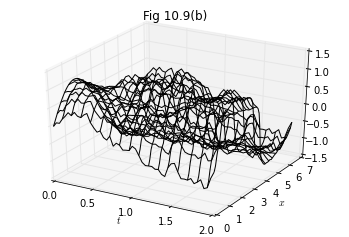

In [82]:
T=2; N=50; a=2*pi; J=64; r=1; epsilon=0.001; sigma=1;
M=2; kappa=1;
x=np.linspace(0,a,J+1); u0=np.sin(x)
s0=np.random.RandomState()
tref,uref,ureft=spde_oned_Gal_MJDt(u0,T,a,N,kappa,J,J,epsilon,
                                   ch3.fAC,
                                   lambda u: sigma,
                                   r,M,s0)    
#
ax = plt.gca()
ax = plt.gca(projection='3d')
[T,X]=np.meshgrid(tref,x)
CS=ax.plot_wireframe(T,X,ureft,rstride=3,cstride=3,colors='k')
#CS=ax.contourf(tref,x,ureft,10,cmap=plt.cm.bone)
#ax.set_zlabel(r'$u$')
s=ax.set_xlabel(r'$t$')
s=ax.set_ylabel(r'$x$')
s=ax.set_title(r'Fig 10.9(b)')

THe generalisation to two spatial dimensions is straight forward.

In [15]:
def spde_twod_Gal(u0,T,a,N,kappa,J,epsilon,fhandle,ghandle,alpha,M):
    """
    Alg 10.11 Page 471
    """
    dtref=T / N;    Dt=kappa * dtref;    t=np.linspace(0,T,N+1)
    #
    lambdax=(2*pi/a[0]) * np.hstack([np.arange(0,J[0]//2+1), np.arange(-J[0]//2+1,0)])
    lambday=(2*pi/a[1]) * np.hstack([np.arange(0,J[1]//2+1), np.arange(-J[1]//2+1,0)])
    lambdaxx,lambdayy=np.meshgrid(lambdax,lambday,indexing='ij')
    Dx=(1j * lambdaxx);    Dy=(1j * lambdayy)
    A=- (Dx ** 2 + Dy ** 2);    MM=np.real(epsilon * A)
    EE=1 / (1 + Dt * MM)
    # initialise noise
    bj=get_twod_bj(dtref,J,a,alpha)
    # initial conditions
    u=np.matlib.tile(u0[:-1,:-1],(M,1,1))
    uh=np.matlib.tile(fft2(u0[:-1,0:-1]),(M,1,1))
    ut=np.zeros((J[0] + 1,J[1] + 1,N//kappa+1))
    ut[:,:,0]=u0
    for n in range(N // kappa):
        fh=fft2(fhandle(u))
        dW,dW2=get_twod_dW(bj,kappa,M)
        gudWh=fft2(ghandle(u)*dW)
        uh_new=EE*(uh + Dt * fh + gudWh)
        u=np.real(ifft2(uh_new))
        ut[:-1,:-1,n + 1]=u[-1,:,:]
        uh=uh_new
    u[:,-1,:] =u[:,0,:];    u[:,:,-1] =u[:,:,0]
    ut[:,-1,:]=ut[:,0,:];   ut[-1,:,:]=ut[0,:,:]
    return t,u,ut
#

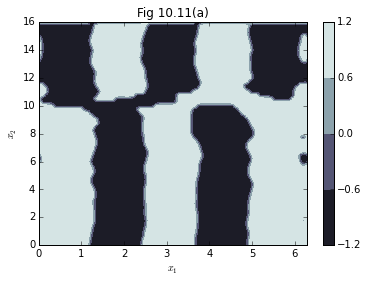

In [83]:
T=10; N=int(1e3); a=np.array([2*pi,16]); J=np.array([128,64])
alpha=0.1; epsilon=1e-3; sigma=0.1; M=2; kappa=1;
x=np.linspace(0,a[0],J[0]+1); y=np.linspace(0,a[1],J[1]+1)
xx,yy=np.meshgrid(x,y,indexing='ij')
# initial data printed in book
# u0=np.sin(xx)*np.cos(pi*yy/8)
# initial data as he intended (x and y switched)
# u0=np.sin(yy)*np.cos(pi*xx/8);
# initial data that gives figure in book
u0=np.sin(xx*8/pi)*np.cos(pi**2*yy/64);
#
t,u,ut=spde_twod_Gal(u0,T,a,N,kappa,J,epsilon,
                     ch3.fAC,
                     lambda u: sigma,
                     alpha,M)
#
ax = plt.gca()
#xx,yy=np.meshgrid(x,y)
CS=ax.contourf(x,y,ut[:,:,-1].T,4,cmap=plt.cm.bone)
plt.colorbar(CS)        
s=ax.set_xlabel(r'$x_1$')
s=ax.set_ylabel(r'$x_2$')
s=ax.set_title(r'Fig 10.11(a)')

We show how to discretise a stochastic reaction-diffusion equation in space with the finite-element method.

In [22]:
import ch2
def spde_fem_MhDt(u0,T,a,Nref,kappa,neref,L,
                  epsilon,fhandle,ghandle,r,M,s0):
    """
    Alg 10.12 Page 473
    """
    ne=neref // L; assert(ne%1 == 0)
    h=(a / ne);    nvtx=ne + 1
    dtref=T / Nref;    Dt=kappa * dtref
    t=np.linspace(0,T,Nref//kappa+1)
    p=epsilon * np.ones(ne);    q=np.ones(ne);    f=np.ones(ne)
    uh,A,b,KK,MM=ch2.oned_linear_FEM(ne,p,q,f)
    EE=MM + Dt * KK
    #
    ZM=np.zeros((M,1))
    #
    bj=get_onedD_bj(dtref,neref,a,r);    bj[ne:-1]=0
    iFspace=0
    #
    u=np.matlib.repmat(u0,M,1)
    ut=np.zeros((nvtx,Nref // kappa + 1));    ut[:,0]=u[0,:]
    b=np.zeros(ne-1); gdw=np.copy(b)
    EEinv=sparse.linalg.factorized(EE)
    for k in range(Nref // kappa):
        dWJ=get_onedD_dW(bj,kappa,iFspace,M,s0)
        dWL=(np.hstack([ZM,dWJ,ZM]));        dWL=dWL[:,::L]
        gdW=ghandle(u)*dWL
        fu=fhandle(u)
        for m in range(M):
            b=ch3.oned_linear_FEM_b(ne,h,fu[m,:])
            gdw=ch3.oned_linear_FEM_b(ne,h,gdW[m,:])
            u1=EEinv(MM.dot(u[m,1:-1]) + Dt * b+gdw)
            u[m,:]=np.hstack([0,u1,0])
        ut[:,k + 1]=u[-1,:]
    return t,u,ut

Here's an example with the Nagumo stochastic PDE.

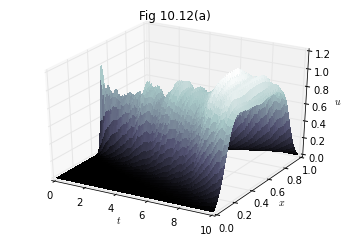

In [84]:
T=10; N=int(1e3); a=1; ne=512; h=a/ne;
epsilon=1e-3; r=1; M=1; sigma=0.1;
x=np.linspace(0,a,ne+1); u0=np.exp(-(x-0.5)**2/epsilon)
s0=np.random.RandomState()
t,u,ut=spde_fem_MhDt(u0,T,a,N,1,ne,1,epsilon,
                     ch3.fNagumo,
                     lambda u:sigma*u,
                     r,M,s0)
#
ax = plt.gca(projection='3d')
[T,X]=np.meshgrid(t,x)
ax.plot_surface(T,X,ut,cmap=cm.bone,linewidth=0, antialiased=False)
s=ax.set_zlabel(r'$u$')
s=ax.set_ylabel(r'$x$')
s=ax.set_xlabel(r'$t$')
s=ax.set_title(r'Fig 10.12(a)') # alternative projection

The remaining codes look at the convergence of the finite-element/semi-implicit Euler approximation as the mesh width $h$ and then time step $\tstep$ are refined.

In [30]:
def spde_fem_convh(u00,T,a,N,neref,L,epsilon,fhandle,ghandle,r,M):
    """
    Alg 10.13 Page 476
    """
    href=a / neref;    xref=np.linspace(0,a,neref+1)
    kappa=1
    s0=np.random.RandomState(); s0_state=s0.get_state()
    t,uref,ureft=spde_fem_MhDt(u00,T,a,N,kappa,neref,1,
                               epsilon,fhandle,ghandle,r,M,s0)
    h=np.empty_like(L, dtype='float64');    S=np.empty_like(h)
    for j, Lval in np.ndenumerate(L):
        h[j]=href * Lval;        u0=u00[::Lval]
        s0.set_state(s0_state)
        t,u,ut=spde_fem_MhDt(u0,T,a,N,kappa,neref,Lval,
                             epsilon,fhandle,ghandle,r,M,s0)
        x=np.linspace(0,a,neref//Lval+1)
        S[j]=np.sum(np.linalg.norm(uref[m,:] - np.interp(xref,x,u[m,:])) ** 2 * href
                    for m in range(M))
    err=np.sqrt(S / M)
    return h,err
#
def spde_fem_convDt(u00,T,a,Nref,kappa,ne,epsilon,fhandle,ghandle,r,M):
    """
    Alg 10.14 Page 477
    """
    dtref=T / Nref;    h=a / ne
    s0=np.random.RandomState()
    s0_state=s0.get_state()
    t,uref,ureft=spde_fem_MhDt(u00,T,a,Nref,1,ne,1,
                               epsilon,fhandle,ghandle,r,M,s0)
    dt=np.empty_like(kappa,dtype='float64'); S=np.empty_like(dt)
    for i, kappaval in np.ndenumerate(kappa):
        dt[i]=kappaval * dtref
        s0.set_state(s0_state)
        t,u,ut=spde_fem_MhDt(u00,T,a,Nref,kappaval,ne,1,
                             epsilon,fhandle,ghandle,r,M,s0)
        S[i]=np.linalg.norm(uref - u,'fro') ** 2 * h
    err=np.sqrt(S / M)
    return dt,err

We choose an example with multiplicative noise.

In [31]:
from numba import vectorize, float64
@vectorize([float64(float64,float64)])
def gquadratic(u,sigma):
    return sigma*u*(1-u)

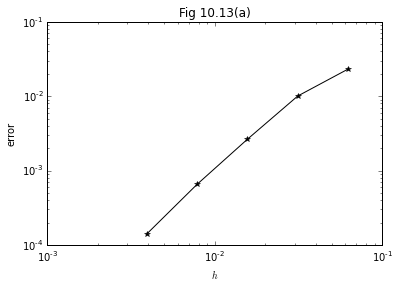

In [97]:
T=1; N=int(1e4); a=1; r=1; sigma=0.5; epsilon=1e-3;
neref=512; href=a/neref; x=np.linspace(0,a,neref+1)
u0=np.exp(-(x-0.5)**2/epsilon)
L=np.array([2,4,8,16,32],dtype='int')
M=1
h,errh=spde_fem_convh(u0,T,a,N,neref,L,epsilon,
                      ch3.fNagumo,
                      lambda u: gquadratic(u,sigma),
                      r,M)
#  
plt.loglog(h,errh,'k-*')
s=plt.xlabel(r'$h$')
s=plt.ylabel(r'error')
s=plt.title(r'Fig 10.13(a)')

In [98]:
T=1; N=int(1e3); a=1; r=1; sigma=0.5; epsilon=1e-3; M=20
Nref=int(1e5); ne=32; h=a/ne; x=np.linspace(0,a,ne+1)
u0=np.exp(-(x-0.5)**2/epsilon)
kappa=np.array([5,10,20,50,100,200,500])
dt,errT=spde_fem_convDt(u0,T,a,Nref,kappa,ne,epsilon,
                        ch3.fNagumo,
                        lambda u:gquadratic(u,sigma),
                        r,M)

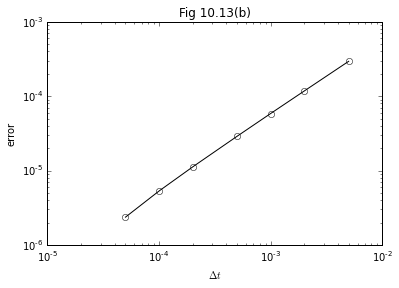

In [99]:
plt.loglog(dt,errT,'-ko',fillstyle='none')
s=plt.xlabel(r'$\Delta t$')
s=plt.ylabel(r'error')
s=plt.title(r'Fig 10.13(b)') # multiplicative noise only